In [ ]:
# Install (versions compatibles + évite le package `keras` standalone)
%pip install -U pip setuptools wheel
%pip install -U tabulate scikit-learn pandas numpy matplotlib seaborn gensim "tensorflow==2.16.1"

https://arxiv.org/abs/2007.12673 - Genetic Algorithm: Reviews, Implementations, and Applications - Tanweer Alam, Shamimul Qamar, Amit Dixit, Mohamed Benaida

# imports

In [1]:
# Suppression des avertissements liés à Scikit-learn
import warnings  # Masquer les avertissements (ex. : FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Librairies générales
import pandas as pd  # Librairie pour la manipulation de données
import numpy as np  # Librairie pour le calcul numérique
import sys  # Fonctions et variables liées à l'interpréteur Python
import copy  # Création de copies d'objets
from numpy import mean, std  # Fonctions de calcul de moyenne et d'écart type
import zipfile  # Traitement de fichiers zip
import os  # Manipulation de fichiers et chemins

# Librairie affichage
import matplotlib.pyplot as plt  # Outils de visualisation 2D
from matplotlib import pyplot  # Interface de la bibliothèque Matplotlib
import seaborn as sns  # Bibliothèque de visualisation de données basée sur Matplotlib

# Scikit-learn pour l'évaluation des modèles
from sklearn.metrics import confusion_matrix  # Matrice de confusion
from sklearn.model_selection import KFold  # Outils de validation croisée
from sklearn.metrics import accuracy_score  # Calcul de l'accuracy
from sklearn.model_selection import train_test_split  # Découpage train/test

# TensorFlow et Keras
import tensorflow as tf  # Librairie de deep learning
import keras  # API haut niveau pour construire et entraîner des modèles de deep learning
from keras import layers  # Modules de couches pour construire des modèles Keras
from keras import models  # Outils pour créer des modèles Keras
from keras import optimizers  # Outils d'optimisation
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Générateur d'images pour l'augmentation des données
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Rappels pour le suivi et l'arrêt précoce
from keras.layers import Input, Dense, Dropout, Flatten, Lambda  # Types de couches Keras
from keras.layers import Conv2D, MaxPooling2D  # Couches convolutionnelles et de pooling
from keras.preprocessing import image  # Outils de prétraitement d'images
from tensorflow.keras.models import Model, load_model  # Définition / chargement de modèles
from keras.datasets import fashion_mnist  # Jeu de données Fashion MNIST
from tensorflow.keras.utils import to_categorical  # Conversion en encodage one-hot
from tensorflow.keras.optimizers import SGD  # Optimiseur Stochastic Gradient Descent
from tensorflow.keras.applications.resnet50 import ResNet50  # Modèle ResNet50 pré-entraîné
from tensorflow.keras.preprocessing import image  # Prétraitement d'images pour les modèles Keras

# DataSet

## File declare

In [2]:
# Définition du répertoire cible
data_dir = "./data/dataset/sheep_cat_elephant_with_caption_600"
data_dir_img = os.path.join(data_dir, "images")
img_height, img_width = 224, 224
batch_size = 32

## Download

In [ ]:
# Création du répertoire s'il n'existe pas
os.makedirs(data_dir, exist_ok=True)

zip_file = "Data_sheep_cat_elephant_with_caption_600.zip"

#!wget https://www.lirmm.fr/~poncelet/Ressources/cnn_models.zip
!Powershell.exe -Command ((new-object System.Net.WebClient).DownloadFile('https://www.lirmm.fr/~poncelet/Ressources/Data_sheep_cat_elephant_with_caption_600.zip','Data_sheep_cat_elephant_with_caption_600.zip'))

# Extraction du fichier ZIP
with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(data_dir)

# Suppression du fichier ZIP après extraction pour économiser de l'espace
os.remove(zip_file)

# GA class

Modèle avec paramètres d'archi modifiables

In [3]:
class ModelInstance:
    def __init__(self, 
                 cLayers, # nombre de couches convolutionnelles
                 cDims, # [(nb_filtres : int, taille_filtres : (int, int), taille_pooling : (int, int))]
                 dLayers, # nombre de couches denses
                 dDims, # [nb_neurones : int]
                 input_shape, # (int, int, int)
                 output_shape, # int
                 name
                 ):
        # couche d'entrée
        input = Input(shape=input_shape, name="input")
        x = input
        # couches conv
        for i in range(cLayers):
            x = Conv2D(cDims[i][0], cDims[i][1], activation="relu", name=f"conv_{i+1}")(x)
            x = MaxPooling2D(cDims[i][2], name=f"pool_{i+1}")(x)
        # flatten
        x = Flatten(name="flatten")(x)
        # couches denses
        for i in range(dLayers):
            x = Dense(dDims[i], activation="relu", name=f"dense_{i+1}")(x)
        # couche de sortie
        output = Dense(output_shape, activation="softmax", name="output")(x)
        model = Model(inputs=input, outputs=output, name=name)
        model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
        self.model = model
        self.cLayers = cLayers
        self.cDims = cDims
        self.dLayers = dLayers
        self.dDims = dDims
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.name = name
    def summary(self):
        return self.model.summary()
    def fit(self, x, y=None, **kwargs):
        return self.model.fit(x, y, **kwargs)
    def evaluate(self, x, y=None, **kwargs):
        return self.model.evaluate(x, y, **kwargs)

    def predict(self, x, **kwargs):
        return self.model.predict(x, **kwargs)

    def save(self, path):
        self.model.save(path)

    def load(self, path):
        self.model = load_model(path)

Gene + Modèle

In [4]:
class Entity:
    def __init__(self,
                 cLayers, # nombre de couches convolutionnelles
                 cDims, # [(nb_filtres : int, taille_filtres : (int, int), taille_pooling : (int, int))]
                 dLayers, # nombre de couches denses
                 dDims, # [nb_neurones : int]
                 input_shape, # (int, int, int)
                 output_shape, # int,
                 name
                 ):
        self.cLayers = cLayers
        self.cDims = cDims
        self.dLayers = dLayers
        self.dDims = dDims
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.model_instance = ModelInstance(cLayers, cDims, dLayers, dDims, input_shape, output_shape, name)
        self.name = name
        self.loss = None
        self.accuracy = None
        self.complexity = self.compute_complexity()
    def evaluate_fitness(self, test_data):
        self.loss, self.accuracy = self.model_instance.evaluate(test_data)
        return self.accuracy
    def compute_complexity(self):
        c = 0.0
        cost_conv = 1.0
        for i in range(self.cLayers):
            c += (self.cDims[i][0] * self.cDims[i][1][0] * self.cDims[i][1][1]) * cost_conv
        cost_dense = 1.5
        for i in range(self.dLayers):
            c += self.dDims[i] * cost_dense
        return c
    def summary(self):
        return self.model_instance.summary()
    def fit(self, x, y=None, **kwargs):
        return self.model_instance.fit(x, y, **kwargs)

    def evaluate(self, x, y=None, **kwargs):
        self.loss, self.accuracy = self.model_instance.evaluate(x, y, **kwargs)
        return self.loss, self.accuracy

    def predict(self, x, **kwargs):
        return self.model_instance.predict(x, **kwargs)

    def reset(self):
        self.model_instance = ModelInstance(
            self.cLayers, self.cDims, self.dLayers, self.dDims, self.input_shape, self.output_shape, self.name
        )
        self.loss = None
        self.accuracy = None
        return self

## Data + train

In [5]:
def load_dataset():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir_img,
        validation_split=0.3,
        subset="training",
        seed=124,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir_img,
        validation_split=0.3,
        subset="validation",
        seed=124,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )

    X_train_list, y_train_list = [], []
    for x, y in train_ds:
        X_train_list.append(x.numpy())
        y_train_list.append(y.numpy())

    X_test_list, y_test_list = [], []
    for x, y in val_ds:
        X_test_list.append(x.numpy())
        y_test_list.append(y.numpy())

    X_train = np.concatenate(X_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)
    X_test = np.concatenate(X_test_list, axis=0)
    y_test = np.concatenate(y_test_list, axis=0)

    # One-hot
    numClass = len(train_ds.class_names)
    y_train = to_categorical(y_train, num_classes=numClass)
    y_test = to_categorical(y_test, num_classes=numClass)

    return X_train, y_train, X_test, y_test

In [6]:
def clean_data(train, test):
    """
    Prétraitement des données : conversion en float, normalisation entre 0 et 1.

    Paramètres :
    - train : tableau de données d'entraînement
    - test : tableau de données de test

    Retourne :
    - train_norm : données d'entraînement normalisées
    - test_norm : données de test normalisées
    """
    # Conversion des entiers en floats pour permettre la normalisation
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')

    # Normalisation des valeurs entre 0 et 1
    train_norm /= 255.0
    test_norm /= 255.0

    return train_norm, test_norm

In [13]:
def evaluate_model(model, dataX, dataY, folds=5, epochs=10):
    """
    Évalue le modèle avec une validation croisée K-fold.

    Paramètres :
    - model : modèle de réseau de neurones Keras à évaluer.
    - dataX : données d'entrée pour l'entraînement et la validation.
    - dataY : étiquettes de sortie correspondantes.
    - folds : nombre de splits pour la validation croisée.
    - epochs : nombre d'époques pour l'entraînement de chaque split.

    Retourne :
    - scores : liste des scores d'accuracy du modèle pour chaque split.
    - histories : liste des historique d'entraînement pour chaque split.
    """
    scores, histories = [], []  # Initialisation des scores et historiques
    kfold = KFold(n_splits=folds, shuffle=True, random_state=1)

    # Itération sur chaque split généré par le K-fold
    for train_ix, test_ix in kfold.split(dataX):
        # Sélection des données d'entraînement et de test pour le fold
        X_train, y_train = dataX[train_ix], dataY[train_ix]
        X_test, y_test = dataX[test_ix], dataY[test_ix]

        # Réinitialisation du modèle avant chaque itération
        model = model.reset()


        # Entraînement du modèle
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=32,
            verbose=0,
        )

        # Évaluation du modèle sur les données de test actuelles
        loss, acc = model.evaluate(X_test, y_test, verbose=0)

        # Stockage de l'historique
        scores.append(acc)
        histories.append(history)

    return scores, histories

In [8]:
def plot_curves(histories):
    """
    Fonction pour afficher les courbes de loss et d'accuracy
    moyennées et écart-types à travers les k-folds.

    Paramètres :
    - histories (list) : Historique d'entraînement des différents plis K-folds.
    """

    # Initialisation des figures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Extraction du nombre d'époques d'après l'un des historiques
    epochs = range(len(histories[0].history['loss']))

    # Calcul des moyennes et des écart-types pour chaque époque
    mean_loss = np.mean([history.history['loss'] for history in histories],
                        axis=0)
    std_loss = np.std([history.history['loss'] for history in histories],
                      axis=0)

    mean_val_loss = np.mean([history.history['val_loss'] for history in histories],
                            axis=0)
    std_val_loss = np.std([history.history['val_loss'] for history in histories],
                          axis=0)

    mean_accuracy = np.mean([history.history['accuracy'] for history in histories],
                            axis=0)
    std_accuracy = np.std([history.history['accuracy'] for history in histories],
                          axis=0)

    mean_val_accuracy = np.mean([history.history['val_accuracy'] for history in histories],
                                axis=0)
    std_val_accuracy = np.std([history.history['val_accuracy'] for history in histories],
                              axis=0)

    # Couleurs pour les courbes
    train_color = 'blue'
    val_color = 'orange'

    # Courbes de loss avec moyenne et écart-type
    ax1.plot(epochs, mean_loss, color=train_color, label='Train')
    ax1.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss,
                     color=train_color, alpha=0.2)

    ax1.plot(epochs, mean_val_loss, color=val_color, label='Validation')
    ax1.fill_between(epochs, mean_val_loss - std_val_loss,
                     mean_val_loss + std_val_loss, color=val_color, alpha=0.2)

    # Courbes d'accuracy avec moyenne et écart-type
    ax2.plot(epochs, mean_accuracy, color=train_color, label='Train')
    ax2.fill_between(epochs, mean_accuracy - std_accuracy,
                     mean_accuracy + std_accuracy, color=train_color, alpha=0.2)

    ax2.plot(epochs, mean_val_accuracy, color=val_color, label='Validation')
    ax2.fill_between(epochs, mean_val_accuracy - std_val_accuracy,
                     mean_val_accuracy + std_val_accuracy,
                     color=val_color, alpha=0.2)

    # Titres, labels et légendes
    ax1.set_title(f'Loss (k={len(histories)})')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title(f'Accuracy (k={len(histories)})')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

In [9]:
def run_evaluation(folds, epochs, model, X_train, y_train, X_test, y_test):
    """
    Fonction d'évaluation

    Cette fonction effectue les étapes suivantes :
    1. Chargement du jeu de données Fashion MNIST.
    2. Prétraitement des données : nettoyage et normalisation.
    3. Initialisation du modèle de base et affichage de sa structure.
    4. Évaluation du modèle avec validation croisée (K-fold).
    5. Affichage des courbes de performance et des statistiques de précision.

    Paramètres :
    - folds (int) : Nombre de splits pour la validation croisée (K-fold).
    - epochs (int) : Nombre d'époques d'entraînement pour chaque pli du K-fold.
    - model : Modèle à évaluer
    Retourne :
    - None
    """

    # Chargement du jeu de données d'entraînement et de test
    #X_train, y_train, X_test, y_test = load_dataset()

    # Prétraitement des données : nettoyage et normalisation
    #X_train, X_test = clean_data(X_train, X_test)

    # Initialisation du modèle de base
    
    print(model.summary())

    # Évaluation du modèle
    scores, histories = evaluate_model(model, X_train, y_train, folds, epochs)

    # Affichage des courbes de performance
    plot_curves(histories)

    # Affichage des statistiques de précision : moyenne et écart-type
    print(f'Précision : moyenne={mean(scores) * 100:.3f}% écart-type={std(scores) * 100:.3f}%, k={len(scores)}')

# GA RUN

## params

In [ ]:
# Base Gene
conv = 4
cDims = [
    (32, (3, 3), (2, 2)),
    (32, (5, 5), (2, 2)),
    (32, (3, 3), (2, 2)),
    (32, (3, 3), (2, 2))
    ]
dense = 1
dDims = [100]
input_shape = (img_height, img_width, 3)
output_shape = 3
# choices :
# 1. Add conv layer
# 2. pop conv layer
# 3. change a conv layer param
#   3.1 change nb_filtres
#   3.2 change taille_filtres
#   3.3 change taille_pooling
# 4. add dense layer
# 5. pop dense layer
# 6. change a dense layer param
#  6.1 change nb_neurones

# Pop params
num_pop = 10
num_gen = 5

## Run

In [11]:
def mutate(conv, cDims, dense, dDims):
    taille_filtres = [(3, 3), (5, 5)]
    nb_filtres = [16, 32, 64, 128]
    taille_pooling = [(2, 2), (3, 3)]
    neur_dense = [50, 100, 200]


    mutation_type = np.random.randint(1, 7)
    if mutation_type == 1: # add conv layer
        conv += 1
        cDims.append((nb_filtres[0], taille_filtres[0], taille_pooling[0]))
    elif mutation_type == 2: # pop conv layer
        if conv > 2:
            conv -= 1
            cDims.pop()
        else:
            mutate(conv, cDims, dense, dDims)
    elif mutation_type == 3: # change a conv layer param
        layer_idx = np.random.randint(0, conv)
        param_idx = np.random.randint(0, 3)
        if param_idx == 0: # change nb_filtres
            cDims[layer_idx] = (np.random.choice(nb_filtres), cDims[layer_idx][1], cDims[layer_idx][2])
        elif param_idx == 1: # change taille_filtres
            cDims[layer_idx] = (cDims[layer_idx][0], taille_filtres[np.random.randint(0, len(taille_filtres))], cDims[layer_idx][2])
        else: # change taille_pooling
            cDims[layer_idx] = (cDims[layer_idx][0], cDims[layer_idx][1], taille_pooling[np.random.randint(0, len(taille_pooling))])
    elif mutation_type == 4: # add dense layer
        dense += 1
        dDims.append(neur_dense[0])
    elif mutation_type == 5: # pop dense layer
        if dense > 1:
            dense -= 1
            dDims.pop()
    else: # change a dense layer param
        if dense > 0:
            layer_idx = np.random.randint(0, dense)
            dDims[layer_idx] = np.random.choice(neur_dense)
        else:
            mutate(conv, cDims, dense, dDims)
    return conv, cDims, dense, dDims

Found 1800 files belonging to 3 classes.
Using 1260 files for training.
Found 1800 files belonging to 3 classes.
Using 540 files for validation.
Generation 1


Model: "0_0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │     3,942,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,943,659 (15.04 MB)

 Trainable params: 3,943,659 (15.04 MB)

 Non-trainable params: 0 (0.00 B)

None
Précision : 55.952%
Précision : 30.714%
Précision : 32.619%


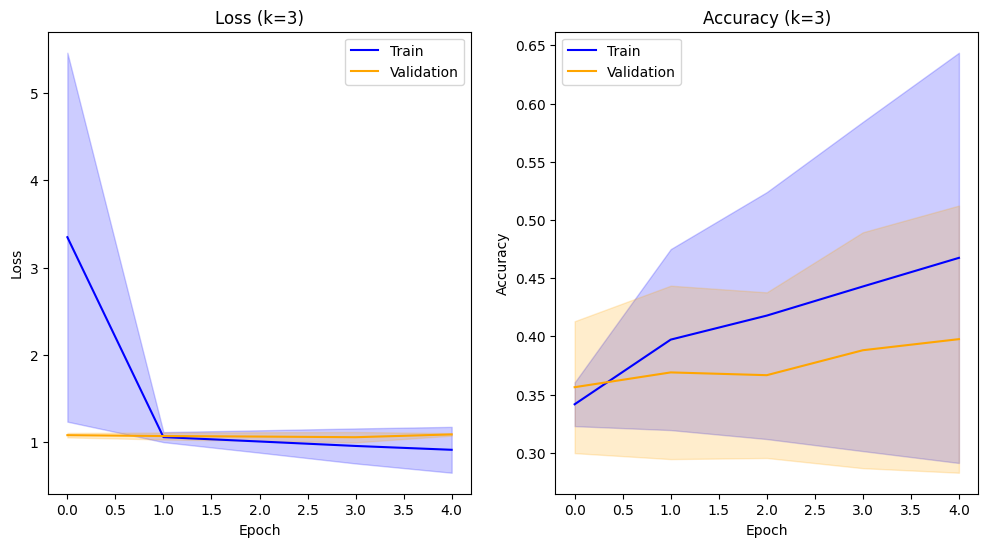

Précision : moyenne=39.762% écart-type=11.475%, k=3


Model: "0_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │    19,713,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,714,699 (75.21 MB)

 Trainable params: 19,714,699 (75.21 MB)

 Non-trainable params: 0 (0.00 B)

None
Précision : 67.143%
Précision : 63.095%


KeyboardInterrupt: 

In [12]:
# Chargement du jeu de données d'entraînement et de test
X_train, y_train, X_test, y_test = load_dataset()

# Prétraitement des données : nettoyage et normalisation
X_train, X_test = clean_data(X_train, X_test)


pop = [Entity(conv, cDims, dense, dDims, input_shape, output_shape, "0_0")] # garder la base pour le controle
for i in range(num_pop - 1):
    pop.append(Entity(*mutate(conv, cDims.copy(), dense, dDims.copy()), input_shape, output_shape, "0_"+str(i+1)))
for i in range(num_gen):
    print(f"Generation {i+1}")
    for entity in pop:
        run_evaluation(folds=3, epochs=5, model=entity, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    # sort by max accuracy
    best_acc = sorted(pop, key=lambda x: x.accuracy, reverse=True)
    best_complexity = sorted(pop, key=lambda x: -x.complexity)
    # sum pos in the two lists
    scores = {}
    for idx, entity in enumerate(pop):
        scores[entity] = best_acc.index(entity) + best_complexity.index(entity)
    # recup best 2
    best_entities = sorted(scores, key=scores.get)[:2]
    # si même score, choisir le plus simple
    if scores[best_entities[0]] == scores[best_entities[1]]:
        best_entities = sorted(best_entities, key=lambda x: x.complexity)[:2]
    # print best entity
    print("Best entity :")
    print(f"Accuracy : {best_entities[0].accuracy:.3f}, Complexity : {best_entities[0].complexity:.3f}")
    print(best_entities[0].summary())
    # generer new pop en mutant la best
    pop = [best_entities[0]]
    for j in range(num_pop - 1):
        pop.append(Entity(
            *mutate( # !!! il a pas mutaté !!!
                best_entities[0].cLayers,
                best_entities[0].cDims.copy(),
                best_entities[0].dLayers,
                best_entities[0].dDims.copy(),
            ),
            input_shape,
            output_shape,
            str(i+1)+"_"+str(j+1)
        ))
print("Final best entity :")
print(f"Accuracy : {best_entities[0].accuracy:.3f}, Complexity : {best_entities[0].complexity:.3f}")
print(best_entities[0].summary())
print(f"param best: conv={best_entities[0].cLayers}, cDims={best_entities[0].cDims}, dense={best_entities[0].dLayers}, dDims={best_entities[0].dDims}")

